In [11]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24)

In [12]:
def read_tejaas(filename):
    rsidlist = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            pvallist.append(pval)
    return rsidlist, pvallist

def read_gene_snplist(filename, rsidlist):
    getres = collections.defaultdict(lambda: False)
    triestr = pygtrie.StringTrie()
    for rsid in rsidlist:
        getres[rsid] = True
        triestr[rsid] = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[1]
            gene = linesplit[0]
            if getres[rsid]:
                if float(linesplit[2]) < 1e-5:
                    triestr[rsid].append(gene)
    return triestr

def read_true_genes(filename):
    truersid = list()
    truestr = pygtrie.StringTrie()
    with open(filename, 'r') as instream:
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[1]
            genes = ['ENSG{:06d}'.format(int(x)) for x in linesplit[4].split(',')]
            truersid.append(rsid)
            truestr[rsid] = genes
    return truersid, truestr

In [15]:
res_common = list()
res_uncommon  = list()
res_false = list()

for sim in range(20):
    simdir = "sim{:03d}".format(sim)
    paramdir = "15158_450_20_800_30_150_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_20_0.02"
    srcdir = os.path.join('/scratch/sbanerj/trans-eqtl/simulation/', paramdir, simdir)
    randfile = os.path.join(srcdir, 'tejaas_rand/permnull_sb0.05/rr.txt')
    rrfile = os.path.join(srcdir, 'tejaas/permnull_sb0.05/rr.txt')
    rrgenefile = os.path.join(srcdir, 'tejaas/permnull_sb0.05/gene_snp_list.txt')
    truefile = os.path.join(srcdir, 'input/expression.trans')
    
    rr_rsids, rr_pvals = read_tejaas(rrfile)
    pvals = np.array(rr_pvals)
    select, pcorr = multitest.fdrcorrection(pvals, alpha = 0.005)
    select_rsids = [rr_rsids[i] for i in np.where(select)[0]]
    select_genes = read_gene_snplist(rrgenefile, select_rsids)
    true_rsids, true_genes = read_true_genes(truefile)
    
    for rsid in select_rsids:
        if len(select_genes[rsid]) > 0:
            if rsid in true_rsids:
                common_genes = len(set(select_genes[rsid]).intersection(true_genes[rsid]))
                uncommon_genes = len(select_genes[rsid]) - common_genes
                res_common.append(common_genes)
                res_uncommon.append(uncommon_genes)
            else:
                false_genes = len(select_genes[rsid])
                res_false.append(false_genes)

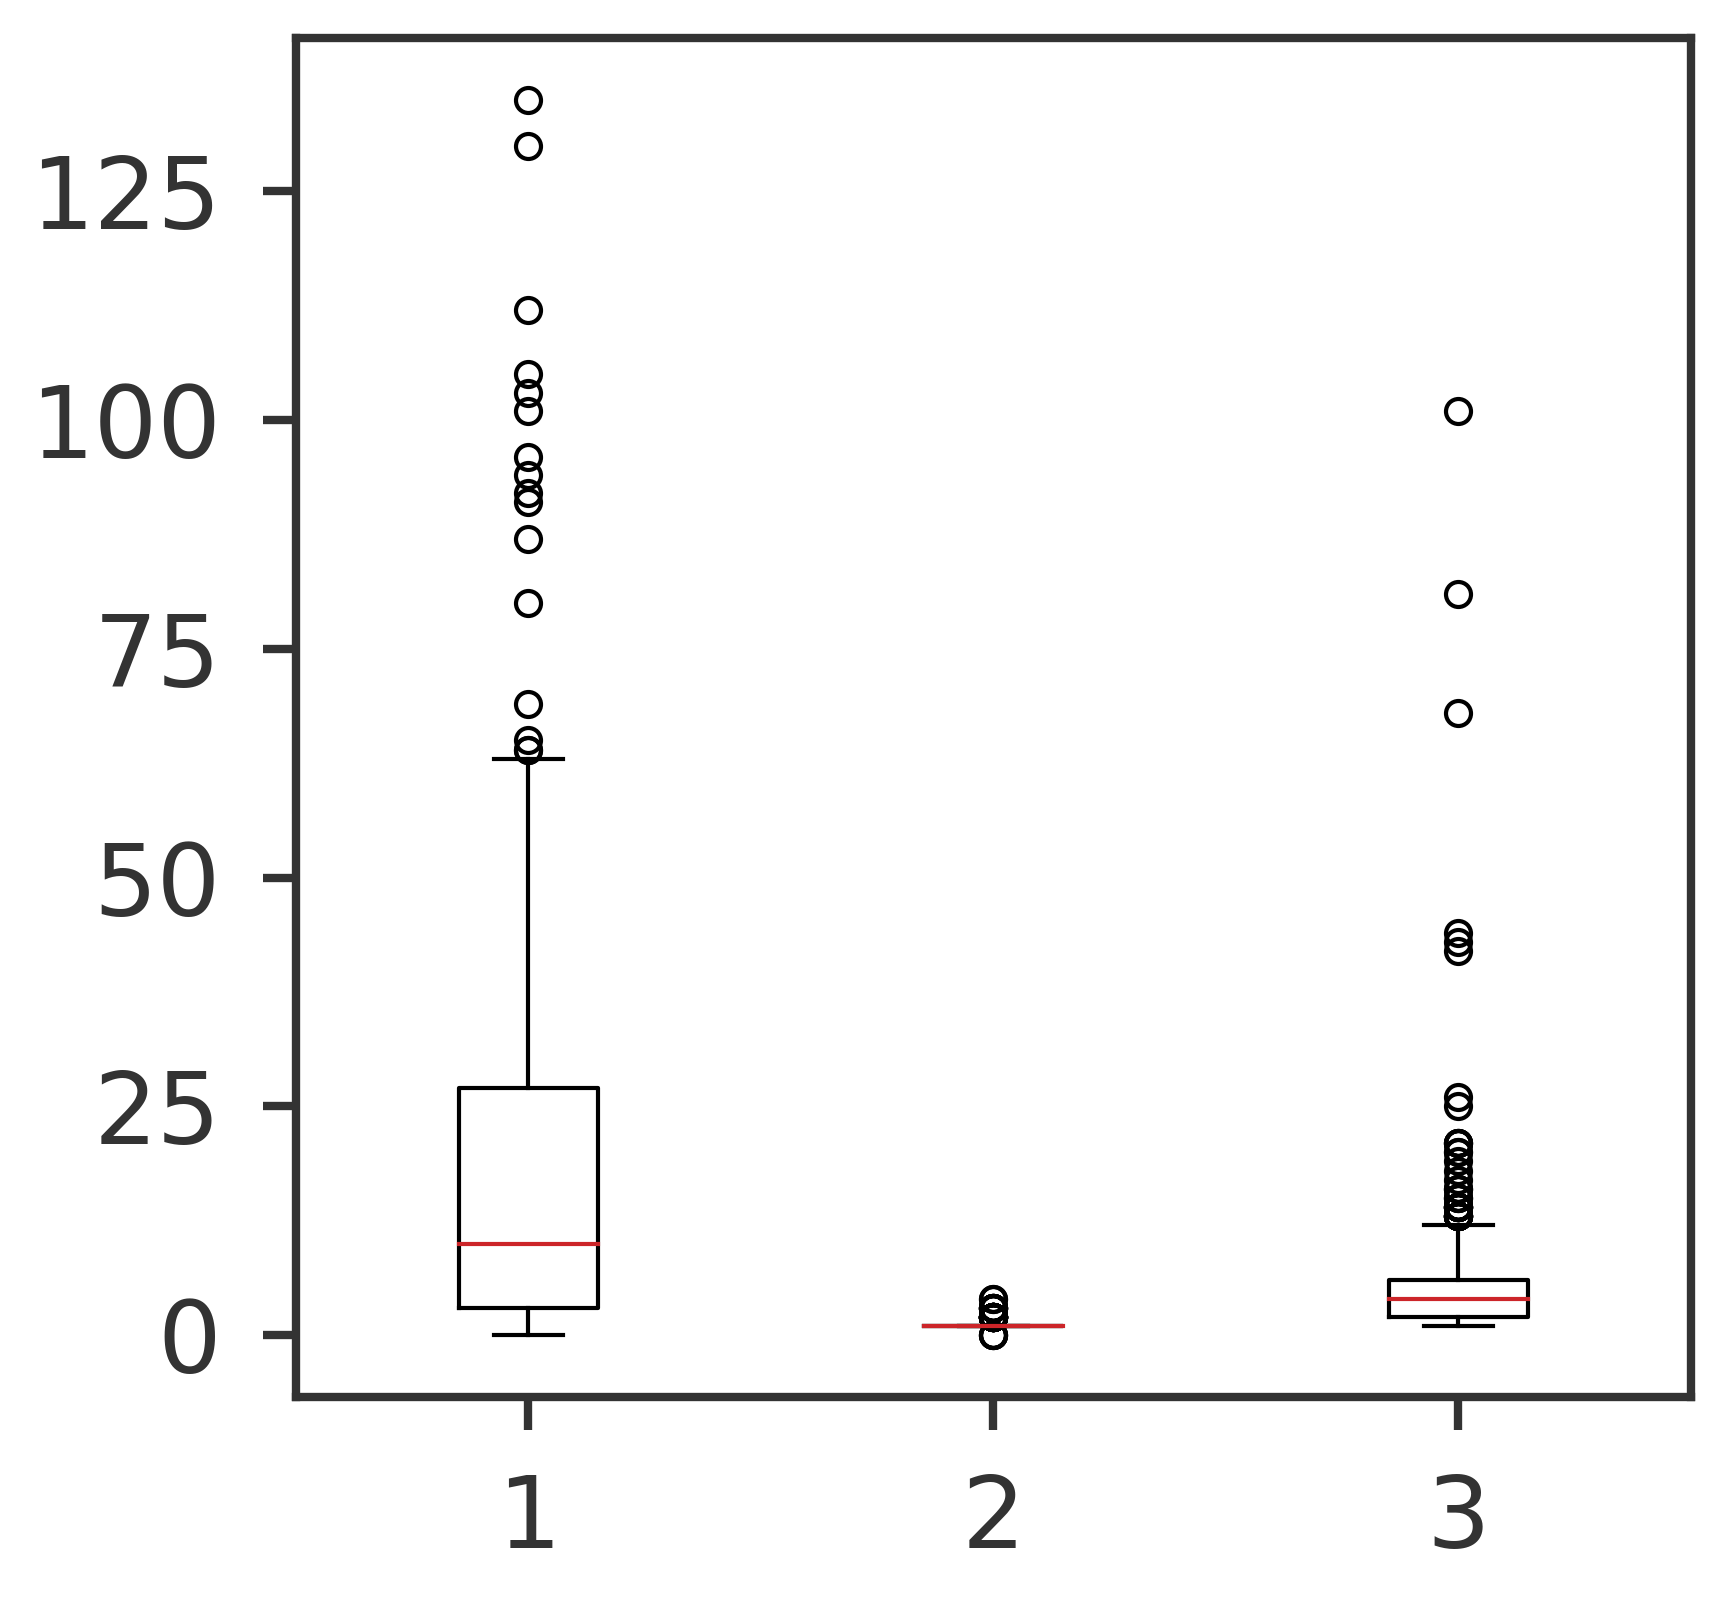

In [16]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.boxplot([res_common, res_uncommon, res_false])
plt.show()